In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.cbook import get_test_data
from metpy.units import units
import os
import scipy.integrate as integrate
import datetime as dt
import glob
import json
from datetime import datetime
from datetime import timedelta
from metpy.plots import ctables
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

#import wrf
import scipy
#import xcape
import xarray

In [2]:
file_dir = '/data/icond2/'
os.chdir(file_dir)

data_det_rr = xr.open_dataset('icond2_precip.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))
data_det_vmax = xr.open_dataset('icond2_vmax.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))
data_det_uhmax = xr.open_dataset('icond2_uh_max.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

KeyError: 'longitude is not a valid dimension or coordinate'

In [3]:
file_dir = '/data/icond2eps/'

# Changing the directory
os.chdir(file_dir)
try:
    os.remove('icond2eps_gust.nc')
    os.remove('icond2eps_vmax_latlon.grib2.923a8.idx')
    os.remove('icond2eps_uhmax_latlon.grib2.923a8.idx')
    os.remove('icond2eps_totprec_latlon.grib2.923a8.idx')
    os.remove('icond2eps_uhmax.nc')
    os.remove('icond2eps_totprec.nc')
except:
    print('no file')

no file


In [4]:
data = xarray.open_dataset('icond2eps_vmax_latlon.grib2', engine='cfgrib')
data.to_netcdf('icond2eps_gust.nc')
data_gust = xr.open_dataset('icond2eps_gust.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

data = xarray.open_dataset('icond2eps_uhmax_latlon.grib2', engine='cfgrib')
data.to_netcdf('icond2eps_uhmax.nc')
data_uhmax = xr.open_dataset('icond2eps_uhmax.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

data = xarray.open_dataset('icond2eps_totprec_latlon.grib2', engine='cfgrib')
data.to_netcdf('icond2eps_totprec.nc')
data_rr = xr.open_dataset('icond2eps_totprec.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

print(data)

Ignoring index file 'icond2eps_vmax_latlon.grib2.923a8.idx' older than GRIB file
Ignoring index file 'icond2eps_uhmax_latlon.grib2.923a8.idx' older than GRIB file
Ignoring index file 'icond2eps_totprec_latlon.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (number: 20, step: 49, latitude: 745, longitude: 1214)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 2 days 00:00:00
    surface     float64 ...
  * latitude    (latitude) float64 43.18 43.2 43.22 43.24 ... 58.02 58.04 58.06
  * longitude   (longitude) float64 -3.94 -3.92 -3.9 -3.88 ... 20.28 20.3 20.32
    valid_time  (step) datetime64[ns] ...
Data variables:
    tp          (number, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2021-07-29T13:46 GRIB to CDM+CF via cfgrib-0.9.9...


In [5]:
# To parse the full dataset, we can call parse_cf without an argument, and assign the returned Dataset.

data_rr = data_rr.metpy.parse_cf()
data_det_rr = data_det_rr.metpy.parse_cf()
data_uh = data_uhmax.metpy.parse_cf()
data_gust = data_gust.metpy.parse_cf()
data_det_vmax = data_det_vmax.metpy.parse_cf()
data_det_uhmax = data_det_uhmax.metpy.parse_cf()

x, y = data_gust['gust'].metpy.coordinates('x', 'y')

time = data_gust['gust'].step
member = data_gust['gust'].number
time2 = data_det_rr['tp'].metpy.time

timeinit = data_gust.time
timeinit = datetime.utcfromtimestamp(timeinit.item()/1e9)
print(timeinit)

uh = data_uh['UH_MAX']
vmax = data_gust['gust']
rr = data_rr['tp']
det_rr = data_det_rr['tp']
det_gust = data_det_vmax['gust']
det_uh = data_det_uhmax['UH_MAX']

#rr.data = np.nan_to_num(rr.data, copy=True, nan=0)
#print(rr.data)

/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "tp".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "UH_MAX".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gust".
  warnings.warn('More than one ' + axis + ' coor

2021-07-29 09:00:00


In [23]:
def plot_background(ax):
    ax.set_extent([5, 7, 49.1, 50.5])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), LineWidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'),LineWidth=1)
    #gl = ax.gridlines(draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    #gl.ylabels_right = False
    #gl.xlabel_style = {'size': 12, 'color': 'black'}
    #gl.ylabel_style = {'size': 12, 'color': 'black'}
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return ax

#import matplotlib
#cmap = matplotlib.cm.get_cmap('cubehelix_r')
#for i in range(20):
    #rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(rgba)
    
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')
newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

cmap2 = ctables.colortables.get_colortable('NWSReflectivity')
newcmap2 = ListedColormap(cmap2(np.linspace(0.2, 0.96, 28)))

cmap4 = ctables.colortables.get_colortable('precipitation')
newcmap4 = ListedColormap(cmap4(np.linspace(0, 0.75, 15)))

colors=[(1,1,1),(0.0, 0.9254901960784314, 0.9254901960784314), 
                        (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                        (0.0, 0.0, 0.9647058823529412), 
                        (0.0, 1.0, 0.0), 
                        (0.0, 0.7843137254901961, 0.0), 
                        (0.0, 0.5647058823529412, 0.0), 
                        (1.0, 1.0, 0.0), 
                        (0.9058823529411765, 0.7529411764705882, 0.0), 
                        (1.0, 0.5647058823529412, 0.0), 
                        (1.0, 0.16078431372, 0.16078431372), 
                        (0.7529411764705882, 0.0, 0.0),
                        (0.59765625, 0.0, 0.0), 
                        (1.0, 0.0, 1.0), 
                        (0.6, 0.3333333333333333, 0.788235294117647),
                         (0.27,0,0.4)]
colors2 = [(1,1,1),
           (0.388235, 0.462745, 0.658824), (0.372549, 0.45098, 0.654902), (0.372549, 0.45098, 0.654902), 
           (0.356863, 0.439216, 0.65098), (0.341176, 0.427451, 0.643137), (0.32549, 0.415686, 0.639216), 
           (0.309804, 0.403922, 0.635294), (0.294118, 0.392157, 0.631373), (0.278431, 0.380392, 0.627451), 
           (0.262745, 0.368627, 0.623529), (0.262745, 0.380392, 0.635294), (0.270588, 0.407843, 0.65098), 
           (0.282353, 0.435294, 0.666667), (0.290196, 0.462745, 0.682353), (0.301961, 0.490196, 0.698039), 
           (0.309804, 0.517647, 0.713725), (0.317647, 0.545098, 0.733333), (0.329412, 0.572549, 0.74902), 
           (0.337255, 0.6, 0.764706), (0.34902, 0.623529, 0.780392), (0.356863, 0.65098, 0.796078), 
           (0.368627, 0.678431, 0.811765), (0.376471, 0.705882, 0.831373), (0.384314, 0.733333, 0.847059), 
           (0.396078, 0.760784, 0.862745), (0.403922, 0.788235, 0.878431), (0.415686, 0.815686, 0.894118),
           (0.435294, 0.839216, 0.909804), (0.407843, 0.839216, 0.843137), (0.380392, 0.839216, 0.772549), 
           (0.34902, 0.839216, 0.701961), (0.321569, 0.839216, 0.635294), (0.294118, 0.839216, 0.564706), 
           (0.262745, 0.839216, 0.494118), (0.235294, 0.839216, 0.427451), (0.207843, 0.839216, 0.356863),
           (0.066667, 0.835294, 0.094118), (0.066667, 0.819608, 0.090196), (0.062745, 0.803922, 0.090196), 
           (0.062745, 0.784314, 0.086275), (0.062745, 0.768627, 0.086275), (0.058824, 0.752941, 0.082353), 
           (0.058824, 0.737255, 0.082353), (0.058824, 0.717647, 0.078431), (0.054902, 0.701961, 0.078431), 
           (0.054902, 0.686275, 0.07451), (0.054902, 0.670588, 0.07451), (0.05098, 0.65098, 0.070588), 
           (0.05098, 0.635294, 0.070588), (0.05098, 0.619608, 0.066667), (0.047059, 0.6, 0.066667), 
           (0.047059, 0.584314, 0.062745), (0.047059, 0.568627, 0.062745), (0.043137, 0.552941, 0.058824),
           (0.043137, 0.533333, 0.058824), (0.043137, 0.517647, 0.054902), (0.039216, 0.501961, 0.054902),
           (0.039216, 0.486275, 0.05098), (0.039216, 0.466667, 0.05098), (0.035294, 0.45098, 0.047059), 
           (0.035294, 0.435294, 0.047059), (0.035294, 0.419608, 0.043137), (0.031373, 0.4, 0.043137),
           (0.031373, 0.384314, 0.039216), (0.035294, 0.368627, 0.035294), (0.113725, 0.407843, 0.035294), 
           (0.196078, 0.45098, 0.031373), (0.27451, 0.490196, 0.031373), (0.356863, 0.533333, 0.027451), 
           (0.435294, 0.572549, 0.027451), (0.517647, 0.615686, 0.023529), (0.596078, 0.658824, 0.023529),
           (0.678431, 0.698039, 0.019608), (0.756863, 0.741176, 0.019608), (0.839216, 0.780392, 0.015686),
           (0.917647, 0.823529, 0.015686), (1.0, 0.886275, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.827451, 0.0), 
           (1.0, 0.788235, 0.0), (1.0, 0.768627, 0.0), (1.0, 0.733333, 0.0), (1.0, 0.713725, 0.0), 
           (1.0, 0.693725, 0.0), (1.0, 0.67451, 0.0), (1.0, 0.654902, 0.0), (1.0, 0.619608, 0.0), 
           (1.0, 0.6, 0.0), (1.0, 0.580392, 0.0), (1.0, 0.541176, 0.0), (1.0, 0.521569, 0.0), 
           (1.0, 0.501569, 0.0), (0.945098, 0.0, 0.0), 
           (0.917647, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.862745, 0.0, 0.0), (0.835294, 0.0, 0.0), 
           (0.803922, 0.0, 0.0), (0.776471, 0.0, 0.0), (0.74902, 0.0, 0.0), (0.721569, 0.0, 0.0), 
           (0.694118, 0.0, 0.0), (0.666667, 0.0, 0.0), (0.639216, 0.0, 0.0), (0.607843, 0.0, 0.0),
           (0.580392, 0.0, 0.0), (0.552941, 0.0, 0.0), (0.52549, 0.0, 0.0), (0.498039, 0.0, 0.0), 
           (0.470588, 0.0, 0.0), (0.443137, 0.0, 0.0), (1.0, 0.960784, 1.0), 
           (1.0, 0.917647, 1.0), (1.0, 0.87451, 1.0), (1.0, 0.831373, 1.0), (1.0, 0.788235, 1.0), 
           (1.0, 0.745098, 1.0), (1.0, 0.701961, 1.0), (1.0, 0.658824, 1.0), (1.0, 0.615686, 1.0), 
           (1.0, 0.572549, 1.0), (1.0, 0.458824, 1.0), (0.988235, 0.419608, 0.992157), 
           (0.976471, 0.376471, 0.980392), (0.964706, 0.337255, 0.968627), (0.952941, 0.294118, 0.956863), 
           (0.941176, 0.25098, 0.945098), (0.929412, 0.211765, 0.937255), (0.917647, 0.168627, 0.92549), 
           (0.905882, 0.12549, 0.913725), (0.894118, 0.086275, 0.901961), (0.882353, 0.043137, 0.890196), 
           (0.698039, 0.0, 1.0), (0.67451, 0.0, 0.988235), (0.643137, 0.0, 0.968627), (0.607843, 0.0, 0.956863),
           (0.576471, 0.0, 0.937255), (0.533333, 0.0, 0.917647), (0.513725, 0.0, 0.909804),
           (0.47451, 0.0, 0.886275), (0.447059, 0.0, 0.866667), (0.411765, 0.0, 0.858824), 
           (0.388235, 0.0, 0.839216)]

colors3 = [(1,1,1), (0.961,0.949,0.847),
          (0.886,0.933,0.776),
          (0.776,0.910,0.737),
           (0.643,0.878,0.718),
          (0.494,0.835,0.722),
          (0.341,0.784,0.737),
          (0.204,0.722,0.753),
          (0.180,0.647,0.761),
          (0.278,0.557,0.757),
          (0.392,0.455,0.725),
          (0.478,0.333,0.671),
          (0.518,0.208,0.565),
          (0.502,0.078,0.431)]

cmap1 = ListedColormap(colors)
newcmap1 = ListedColormap(cmap1(np.linspace(0, 1, 17)))

cmap3 = ListedColormap(colors3)
newcmap3 = ListedColormap(cmap3(np.linspace(0, 1, 14)))
bounds = [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50,55]
norm = BoundaryNorm(bounds, newcmap4.N)
bounds6 = [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110]
norm6 = BoundaryNorm(bounds6, newcmap4.N)
bounds24 = [0,0.1,5,10,20,30,40,50,60,70,80,90,100,110,120,130]
norm24 = BoundaryNorm(bounds6, newcmap4.N)

#cmap2 = ListedColormap(colors2)
#newcmap2 = ListedColormap(cmap2(np.linspace(0, 0.9, 29)))

In [10]:
# Create the figure and plot background on different axes
for i in range(1,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)
        
    time2 = data_det_uhmax['UH_MAX'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    clevs_uh = np.arange(50,850,50)
    #clevs_gust = np.arange(50,210,20)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_uhmax.longitude, data_det_uhmax.latitude, det_uh.metpy.loc[{'time': time2[i-1]}]*3.6, 
                          clevs_uh, cmap='tab20b', extend='max', transform=ccrs.PlateCarree())
    #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                     #[15,25,35], colors='black', transform=ccrs.PlateCarree())
    #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[20].set_title('Deterministic', fontsize=16)

    for j in range(0,20):
    
        # Upper left plot
        cf1 = axlist[j].contourf(data_uhmax.longitude, data_uhmax.latitude, uh.metpy.loc[{'step': time[i], 'number': member[j]}]*3.6, 
                          clevs_uh, cmap='tab20b', extend='max', transform=ccrs.PlateCarree())
        #ccf1= axlist[0].contour(gust.longitude, gust.latitude, gust.metpy.loc[{'time': time[i]}]*3.6,
                         #clevs_gust, colors='darkviolet', transform=ccrs.PlateCarree())
        #axlist[0].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')



    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical', 
                      ticks=(0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('m²/s²', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: 1-hourly Maximum Updraft Helicity', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_uhmax_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=100)
    plt.close(fig)

icond2eps_uhmax_1.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_2.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_3.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_4.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_5.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_6.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_7.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_8.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_9.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_10.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_11.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_12.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_13.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_14.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_15.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_16.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_17.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_18.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_19.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_20.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_21.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_22.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_23.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_24.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_25.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_26.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_27.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_28.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_29.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_30.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_31.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_32.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_33.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_34.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_35.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_36.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_37.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_38.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_39.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_40.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_41.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_42.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_43.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_44.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_45.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_46.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_47.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_uhmax_48.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


In [11]:
# Create the figure and plot background on different axes
for i in range(1,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)

    time2 = data_det_rr['tp'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    #clevs_uh = np.arange(0,650,50)
    clevs_rr = np.arange(0,60,5)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_rr.longitude, data_det_rr.latitude, det_rr.metpy.loc[{'time': time2[i]}]-det_rr.metpy.loc[{'time': time2[i-1]}], 
                          [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50,55], cmap=newcmap4, norm=norm, extend='max',transform=ccrs.PlateCarree())
    #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                     #[15,25,35], colors='black', transform=ccrs.PlateCarree())
    #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[20].set_title('Deterministic', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                              #shrink=1, fraction=0.03, pad=0)
    #cb1.set_label('dBZ', size='x-large')

    for j in range(0,20):
    
        
        cf1 = axlist[j].contourf(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}], 
                          [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50,55], cmap=newcmap4, norm=norm, extend='max',transform=ccrs.PlateCarree())
        #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                         #[15,25,35], colors='black', transform=ccrs.PlateCarree())
        #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')

    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('mm', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: 1-hourly Total Precipitation', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_rr_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=100)
    plt.close(fig)

icond2eps_rr_1.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_2.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_3.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_4.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_5.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_6.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_7.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_8.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_9.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_10.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_11.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_12.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_13.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_14.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_15.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_16.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_17.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_18.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_19.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_20.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_21.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_22.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_23.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_24.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_25.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_26.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_27.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_28.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_29.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_30.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_31.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_32.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_33.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_34.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_35.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_36.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_37.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_38.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_39.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_40.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_41.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_42.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_43.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_44.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_45.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_46.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_47.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr_48.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


In [21]:
# Create the figure and plot background on different axes
for i in range(6,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)

    time2 = data_det_rr['tp'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    #clevs_uh = np.arange(0,650,50)
    clevs_rr = np.arange(0,60,5)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_rr.longitude, data_det_rr.latitude, det_rr.metpy.loc[{'time': time2[i]}]-det_rr.metpy.loc[{'time': time2[i-6]}], 
                          [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110], cmap=newcmap4, norm=norm6, extend='max',transform=ccrs.PlateCarree())
    #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                     #[15,25,35], colors='black', transform=ccrs.PlateCarree())
    #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[20].set_title('Deterministic', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                              #shrink=1, fraction=0.03, pad=0)
    #cb1.set_label('dBZ', size='x-large')

    for j in range(0,20):
    
        
        cf1 = axlist[j].contourf(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-6], 'number': member[j]}], 
                          [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110], cmap=newcmap4, norm=norm6, extend='max',transform=ccrs.PlateCarree())
        #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                         #[15,25,35], colors='black', transform=ccrs.PlateCarree())
        #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')

    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('mm', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: 6-hourly Total Precipitation', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_rr6_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=100)
    plt.close(fig)

icond2eps_rr6_6.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_7.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_8.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_9.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_10.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_11.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_12.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_13.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_14.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_15.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_16.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_17.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_18.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_19.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_20.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_21.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_22.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_23.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_24.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_25.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_26.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_27.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_28.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_29.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_30.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_31.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_32.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_33.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_34.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_35.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_36.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_37.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_38.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_39.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_40.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_41.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_42.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_43.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_44.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_45.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_46.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_47.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr6_48.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


In [22]:
# Create the figure and plot background on different axes
for i in range(12,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)

    time2 = data_det_rr['tp'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    #clevs_uh = np.arange(0,650,50)
    clevs_rr = np.arange(0,60,5)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_rr.longitude, data_det_rr.latitude, det_rr.metpy.loc[{'time': time2[i]}]-det_rr.metpy.loc[{'time': time2[i-12]}], 
                          [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110], cmap=newcmap4, norm=norm6, extend='max',transform=ccrs.PlateCarree())
    #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                     #[15,25,35], colors='black', transform=ccrs.PlateCarree())
    #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[20].set_title('Deterministic', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                              #shrink=1, fraction=0.03, pad=0)
    #cb1.set_label('dBZ', size='x-large')

    for j in range(0,20):
    
        
        cf1 = axlist[j].contourf(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-12], 'number': member[j]}], 
                          [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110], cmap=newcmap4, norm=norm6, extend='max',transform=ccrs.PlateCarree())
        #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                         #[15,25,35], colors='black', transform=ccrs.PlateCarree())
        #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')

    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('mm', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: 12-hourly Total Precipitation', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_rr12_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=100)
    plt.close(fig)

icond2eps_rr12_12.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_13.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_14.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_15.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_16.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_17.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_18.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_19.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_20.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_21.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_22.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_23.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_24.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_25.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_26.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_27.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_28.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_29.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_30.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_31.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_32.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_33.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_34.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_35.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_36.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_37.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_38.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_39.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_40.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_41.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_42.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_43.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_44.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_45.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_46.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_47.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr12_48.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


In [24]:
# Create the figure and plot background on different axes
for i in range(24,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)

    time2 = data_det_rr['tp'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    #clevs_uh = np.arange(0,650,50)
    clevs_rr = np.arange(0,60,5)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_rr.longitude, data_det_rr.latitude, det_rr.metpy.loc[{'time': time2[i]}]-det_rr.metpy.loc[{'time': time2[i-24]}], 
                          [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110], cmap=newcmap4, norm=norm6, extend='max',transform=ccrs.PlateCarree())
    #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                     #[15,25,35], colors='black', transform=ccrs.PlateCarree())
    #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[20].set_title('Deterministic', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                              #shrink=1, fraction=0.03, pad=0)
    #cb1.set_label('dBZ', size='x-large')

    for j in range(0,20):
    
        
        cf1 = axlist[j].contourf(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-24], 'number': member[j]}], 
                          [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110], cmap=newcmap4, norm=norm6, extend='max',transform=ccrs.PlateCarree())
        #ccf1= axlist[j].contour(data_rr.longitude, data_rr.latitude, rr.metpy.loc[{'step': time[i], 'number': member[j]}]-rr.metpy.loc[{'step': time[i-1], 'number': member[j]}],
                         #[15,25,35], colors='black', transform=ccrs.PlateCarree())
        #axlist[j].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')

    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('mm', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: 24-hourly Total Precipitation', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_rr24_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=100)
    plt.close(fig)

icond2eps_rr24_24.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_25.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_26.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_27.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_28.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_29.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_30.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_31.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_32.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_33.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_34.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_35.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_36.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_37.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_38.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_39.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_40.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_41.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_42.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_43.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_44.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_45.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_46.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_47.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_rr24_48.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_vmax_1.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_vmax_2.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


error
icond2eps_vmax_3.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_vmax_4.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_vmax_5.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_vmax_6.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_vmax_7.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


KeyboardInterrupt: 

/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


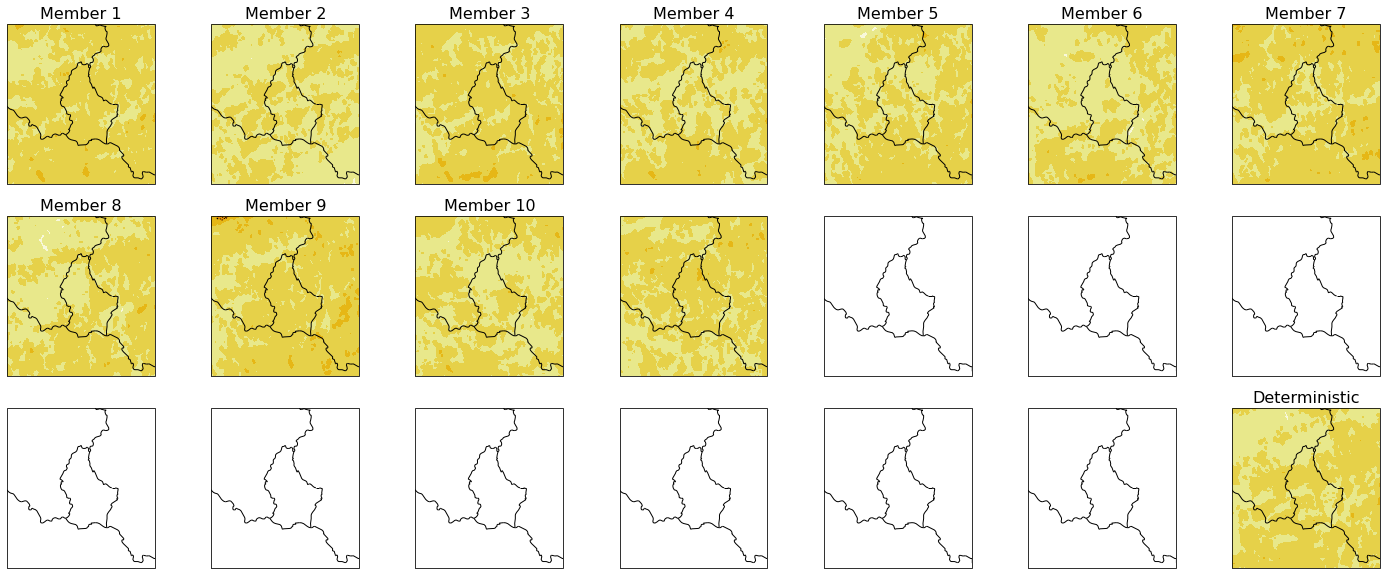

In [12]:
# Create the figure and plot background on different axes
for i in range(1,49):
    
    timestep=timeinit+timedelta(hours=i)
    crs = ccrs.Mercator()
    
    fig, axarr = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), constrained_layout=False,
                              subplot_kw={'projection': crs})

    axlist = axarr.flatten()
    for ax in axlist:
        plot_background(ax)
        
    time2 = data_det_vmax['gust'].metpy.time
    #clevs_dbz = np.arange(-2.5,72.5,2.5)
    #clevs_uh = np.arange(0,650,50)
    clevs_gust = np.arange(10,150,10)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
    
    cf1 = axlist[20].contourf(data_det_vmax.longitude, data_det_vmax.latitude, det_gust.metpy.loc[{'time': time2[i-1]}]*3.6, 
                          clevs_gust, cmap='CMRmap_r', extend='max',transform=ccrs.PlateCarree())
    ccf1= axlist[20].contour(data_det_vmax.longitude, data_det_vmax.latitude, det_gust.metpy.loc[{'time': time2[i-1]}]*3.6,
                     [50,70,90,110], colors='black', linestyles='dotted', linewidths=1, transform=ccrs.PlateCarree())
    try:
        axlist[20].clabel(ccf1,fontsize=8, inline=1, inline_spacing=3, fmt='%i',  rightside_up=True)
    except:
        print('error')
    axlist[20].set_title('Deterministic', fontsize=16)

    for j in range(0,20):
    
        # Upper left plot
        cf1 = axlist[j].contourf(data_gust.longitude, data_gust.latitude, vmax.metpy.loc[{'step': time[i], 'number': member[j]}]*3.6, 
                          clevs_gust, cmap='CMRmap_r', extend='max', transform=ccrs.PlateCarree())
        ccf1= axlist[j].contour(data_gust.longitude, data_gust.latitude, vmax.metpy.loc[{'step': time[i], 'number': member[j]}]*3.6,
                         [50,70,90,110],  colors='black', linestyles='dotted', linewidths=1, transform=ccrs.PlateCarree())
        try:
            axlist[j].clabel(ccf1,fontsize=8, inline=1, inline_spacing=3, fmt='%i',  rightside_up=True)
        except:
            print('error')
        axlist[j].set_title('Member '+str(j+1), fontsize=16)
        #cb1= fig.colorbar(cf1, ax=axlist[j], orientation='vertical',
                                  #shrink=1, fraction=0.03, pad=0)
        #cb1.set_label('dBZ', size='x-large')



    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130), fraction=0.03, aspect=30, pad=0.02)
    cb.set_label('km/h', size='x-large')
    # Set figure title
    plt.gcf().text(0.135, 0.98, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.135, 0.94, 'Parameter: 1-hourly Maximum Wind Gust', fontsize=20)
    #plt.gcf().text(0.6, 0.94, timeinit.strftime('Init: %d.%m.%Y %H:%M UTC / ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    #plt.gcf().text(0.55, 0.09, 'Note: Updraft helicity is vertically averaged between 500 and 6000 m AGL.', fontsize=10)

    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_vmax_'
    suffix='.jpeg'
    latest='latest'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=100)
    plt.close(fig)